# Fees & Trade Costs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MiniXC/simple-back/blob/master/docs/intro/fees.ipynb)

Some strategies can fall apart when broker commissions are taken into account. The `FlatPerFee` and `FlatPerShare` fees come with simple-back, but you can define your own fees by extending the `Fee` class.

In [ ]:
%%capture
!pip install --upgrade simple_back

In [1]:
from simple_back.backtester import BacktesterBuilder

builder = (
   BacktesterBuilder()
   .name('AAPL without Fees')
   .balance(10_000)
   .calendar('NYSE')
   .compare(['AAPL'])
   .live_progress()
   .live_plot()
)

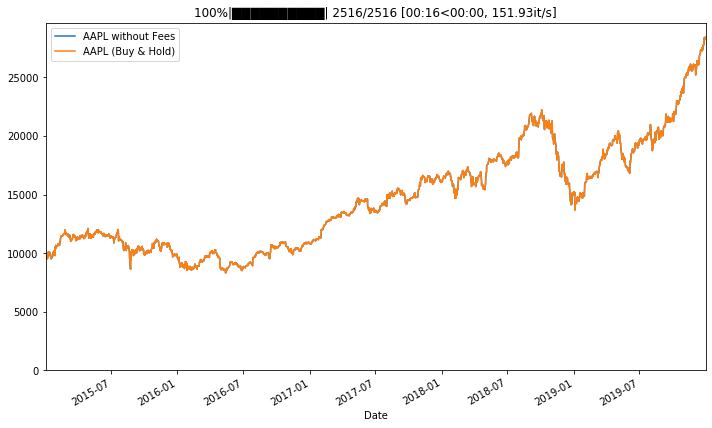

In [2]:
bt = builder.build()
for day, event, b in bt['2015-1-1':'2020-1-1']:
    b.pf.liquidate()
    b.long('AAPL', percent=1)

## Flat Fees

As you can see, selling & buying AAPL at every open and close results in the same as simply buying it once and holding it. But for many brokers, this is not realistic. Let's assume we have to pay a flat commission of 1 dollar per trade. We can do this using `FlatPerTrade`.

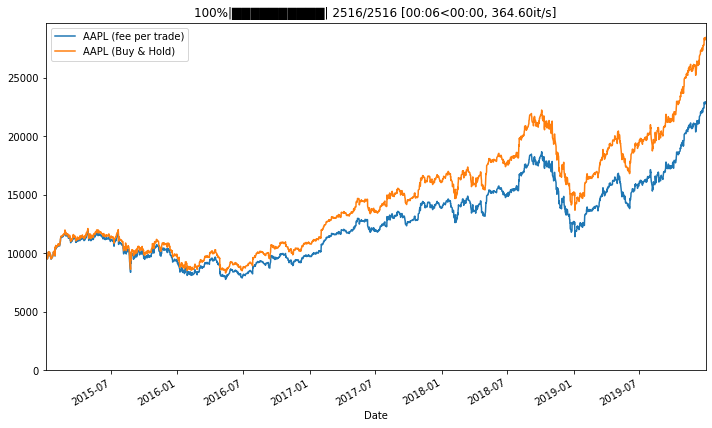

In [3]:
from simple_back.fees import FlatPerTrade

bt = (
    builder
    .name('AAPL (fee per trade)')
    .trade_cost(FlatPerTrade(1))
    .build()
)

for day, event, b in bt['2015-1-1':'2020-1-1']:
    b.pf.liquidate()
    b.long('AAPL', percent=1)

We can also assume a flat commission of 5 cents per share.

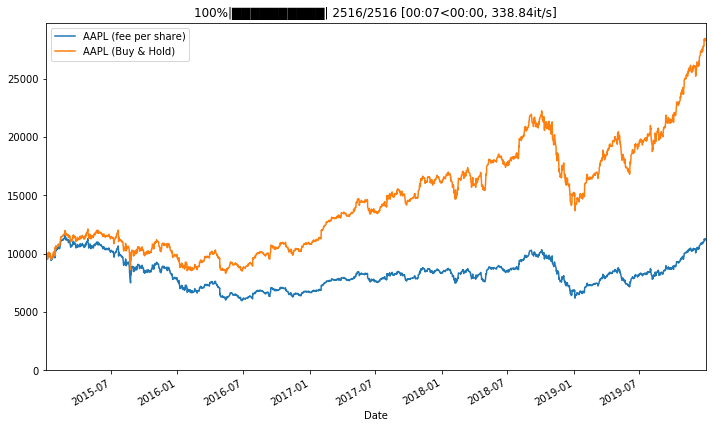

In [4]:
from simple_back.fees import FlatPerShare

bt = (
    builder
    .name('AAPL (fee per share)')
    .trade_cost(FlatPerShare(.05))
    .build()
)

for day, event, b in bt['2015-1-1':'2020-1-1']:
    b.pf.liquidate()
    b.long('AAPL', percent=1)

## Custom Fees
Let's now build a custom `Fee` that charges a percentage of the total cost.

In [5]:
from simple_back.fees import Fee

In [6]:
class PercentageFee(Fee):
    
    def __init__(self, fee_percent):
        self.fee_percent = fee_percent
    
    def nshares(self, price, capital):
        return (capital * (1/(1 + self.fee_percent))) // price

    def cost(self, price, nshares):
        return price * nshares * (1 + self.fee_percent)

For testing we can treat our `Fee` object like a callable.

In [7]:
PercentageFee(.5)(price=10,capital=1000)

{'nshares': 66.0, 'total': 990.0, 'fee': 330.0}

The above means that when we have a security with price 10 and our capital is 1000, we can buy 66 shares for a total of 990 and of that 990, 330 will be fees.

Now, we can use our `PercentageFee` in our backtest.

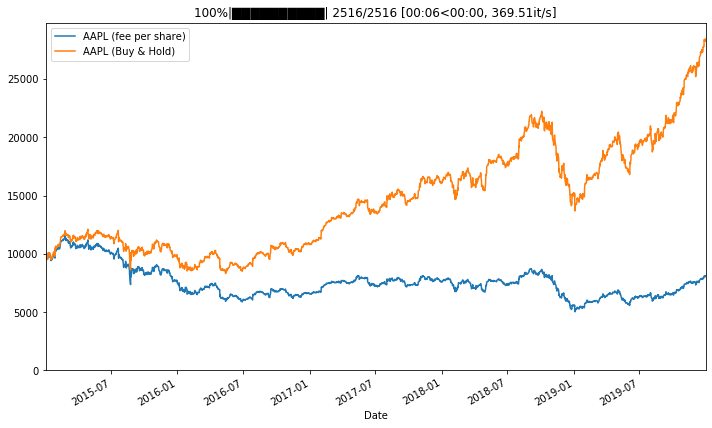

In [8]:
bt = (
    builder
    .name('AAPL (fee per share)')
    .trade_cost(PercentageFee(.0005)) # 0.05 % 
    .build()
)

for day, event, b in bt['2015-1-1':'2020-1-1']:
    b.pf.liquidate()
    b.long('AAPL', percent=1)

Fees are saved in the trade history as well.

In [9]:
bt.trades.df

,date,end_date,end_event,event,fee,initial_value,nshares,order_type,price,profit_loss_abs,profit_loss_pct,start_price,symbol,value,value_pershare
0,2015-01-02,2015-01-02,close,open,4.989624,9984.238150,98.0,long,99.945885,-189.541449,-0.018984,101.829067,AAPL,9794.696701,99.945885
1,2015-01-02,2015-01-05,open,close,4.897348,9799.594049,98.0,long,98.995143,-98.070049,-0.010008,99.945885,AAPL,9701.524001,98.995143
2,2015-01-05,2015-01-05,close,open,4.850762,9706.374763,98.0,long,97.130241,-187.611106,-0.019329,98.995143,AAPL,9518.763657,97.130241
3,2015-01-05,2015-01-06,open,close,4.759382,9523.523038,98.0,long,97.395385,21.224719,0.002229,97.130241,AAPL,9544.747758,97.395385
4,2015-01-06,2015-01-06,close,open,4.723676,9452.076049,97.0,long,97.139420,-29.552352,-0.003127,97.395385,AAPL,9422.523697,97.139420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2019-12-27,2019-12-27,close,open,3.910230,7824.369503,27.0,long,288.333313,-39.370053,-0.005032,289.646640,AAPL,7784.999451,288.333313
2511,2019-12-27,2019-12-30,open,close,3.892500,7788.891950,27.0,long,287.995045,-13.025743,-0.001672,288.333313,AAPL,7775.866207,287.995045
2512,2019-12-30,2019-12-30,close,open,3.887933,7779.754140,27.0,long,290.044617,51.450510,0.006613,287.995045,AAPL,7831.204651,290.044617
2513,2019-12-30,2019-12-31,open,close,3.915602,7835.120253,27.0,long,288.462644,-46.628859,-0.005951,290.044617,AAPL,7788.491394,288.462644


Profit and loss also includes the fees.